In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/ext-daniel-packer/documents/noteboooks/neural-geometry


In [2]:
import jax.numpy as jnp
from jax import random
import jax
from ott.solvers import quadratic
import ott
import matplotlib.pyplot as plt
rngs = random.split(random.PRNGKey(seed=2), 10)

In [3]:
# embedding_1 = jnp.load("data/train_embeddings_1.npy")
# embedding_2 = jnp.load("data/train_embeddings_2.npy")

embedding_1 = jnp.load("data/same_architecture_different_initialization/train_embeddings_1.npy")
embedding_2 = jnp.load("data/same_architecture_different_initialization/train_embeddings_2.npy")

labels = jnp.load("data/same_architecture_different_initialization/train_labels.npy")

In [4]:
def randomly_subsample(rng, embedding, labels, n):
    idx = random.choice(rng, embedding.shape[0], (n,), replace=False)
    return embedding[idx], labels[idx]

In [5]:
n_samples = 1_500
embedding_1_subsampled, labels_1_subsampled = randomly_subsample(rngs[0], embedding_1, labels, n_samples)
sorter_by_labels_1 = jnp.argsort(labels_1_subsampled.argmax(1))
embedding_1_sorted = embedding_1_subsampled[sorter_by_labels_1]
labels_1_sorted = labels_1_subsampled[sorter_by_labels_1]

embedding_2_subsampled, labels_2_subsampled = randomly_subsample(rngs[0], embedding_2, labels, n_samples)
sorter_by_labels_2 = jnp.argsort(labels_2_subsampled.argmax(1))
embedding_2_sorted = embedding_2_subsampled[sorter_by_labels_2]
labels_2_sorted = labels_2_subsampled[sorter_by_labels_2]

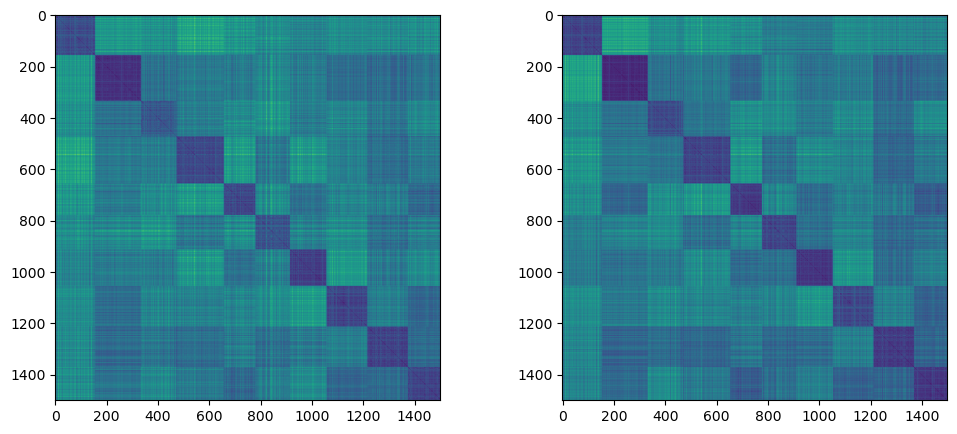

In [16]:
def dist(x, y):
    return jnp.sqrt(jnp.sum(jnp.square(x - y)))

def dist(x, y):
    return jnp.sqrt(jnp.sum(jnp.square(x - y)))


dist_vec = jax.vmap(dist, (None, 0))

def dist_matrix(embedding_a, embedding_b=None):
    embedding_b = embedding_a if embedding_b is None else embedding_b
    return jax.lax.scan(lambda _carry, pt: (_carry, dist_vec(pt, embedding_b)), init=0, xs=embedding_a)
    
_carry, distances_1 = dist_matrix(embedding_1_sorted)
_carry, distances_2 = dist_matrix(embedding_2_sorted)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(distances_1)
axs[1].imshow(distances_2)
# distances
# distances

In [17]:
def get_reduced_dmatrix(distances, labels):
    output = jnp.zeros([10, 10])
    for i in range(10):
        for j in range(10):
            indexer_a = jnp.where(labels.argmax(1) == i)[0]
            indexer_b = jnp.where(labels.argmax(1) == j)[0]
            ab_distances_1 = distances[indexer_a][:, indexer_b]
            output = output.at[i, j].set(jnp.mean(ab_distances_1))
    return output

reduced_distances_1 = get_reduced_dmatrix(distances_1, labels_1_sorted)
reduced_distances_2 = get_reduced_dmatrix(distances_2, labels_2_sorted)
# indexer[0]

In [18]:
geom_1_reduced = ott.geometry.geometry.Geometry(cost_matrix = reduced_distances_1)
geom_2_reduced = ott.geometry.geometry.Geometry(cost_matrix = reduced_distances_2)
problem = ott.problems.quadratic.quadratic_problem.QuadraticProblem(geom_1_reduced, geom_2_reduced, scale_cost=True)

solver = quadratic.lower_bound.LowerBoundSolver(epsilon=0.05)
# solver = quadratic.gromov_wasserstein.GromovWasserstein(epsilon=10.0)
soln = solver(problem)

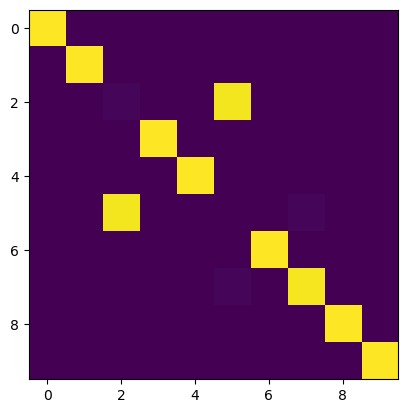

In [19]:
plt.imshow(soln.matrix)

In [20]:
geom_1 = ott.geometry.pointcloud.PointCloud(embedding_1_sorted, scale_cost="mean")
geom_2 = ott.geometry.pointcloud.PointCloud(embedding_2_sorted, scale_cost="mean")

problem = ott.problems.quadratic.quadratic_problem.QuadraticProblem(geom_1, geom_2, scale_cost=True)

In [21]:
solver = quadratic.lower_bound.LowerBoundSolver(epsilon=0.05)

In [22]:
soln = solver(problem)

In [23]:
print(f"{soln.converged=}")

soln.converged=Array(True, dtype=bool)


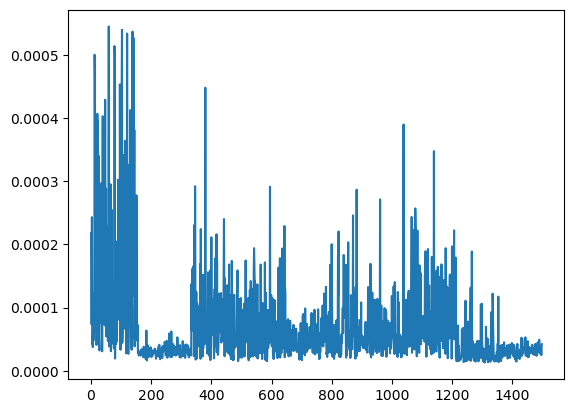

In [26]:
plt.plot(soln.apply(labels_1_sorted[:, 0]))

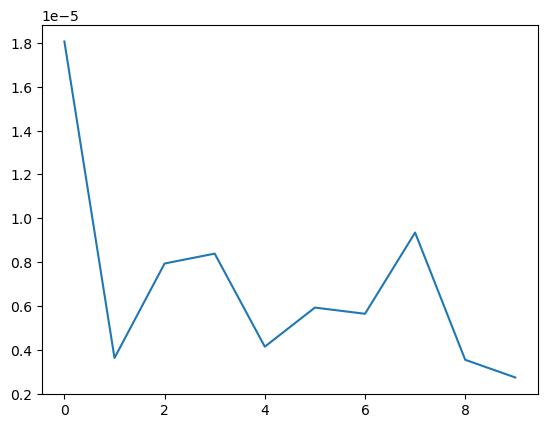

In [27]:
plt.plot((soln.apply(labels_1_sorted[:, 0])[:, None] * labels_2_sorted).mean(0))

In [27]:
embedding_2_sorted[0]

Array([58.6917   , -3.4405072, 47.32245  , 32.920216 , 61.89396  ,
       12.565403 , 23.553373 , -1.840728 , 25.87221  , -1.3018072],      dtype=float32)